<a href="https://colab.research.google.com/github/FerCipriani/Primeros/blob/main/IVE_autoencoders_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.codificandobits.com/blog/autoencoders-explicacion-y-tutorial-python/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/DataSets/IVEDip.xls")
data.head() # Miramos las primeras filas

,Ord,Archivo,ETQ,T0,T1,T2,T3,T4
0,0,ABSTENCION Frente de Todos Jujuy FERREYRA...,ABSTENCION,0.001808,0.001794,0.022661,0.615321,0.358416
1,1,ABSTENCION Frente de Todos Misiones BARBA...,ABSTENCION,0.103556,0.001277,0.020778,0.447274,0.427115
2,2,ABSTENCION PRO C A B A PATInO JosE Luis...,ABSTENCION,0.310341,0.001036,0.077210,0.076255,0.535158
3,3,AFIRMATIVO Coalicion Civica C A B A FERRA...,AFIRMATIVO,0.000575,0.168929,0.073724,0.093982,0.662790
4,4,AFIRMATIVO Frente de la Concordia Misione...,AFIRMATIVO,0.088980,0.001149,0.027057,0.088728,0.794086


In [ ]:
data=data.drop(['Ord', 'Archivo'], axis=1) # Elimino la columna Ord y Archivo
data.head(2)

,ETQ,T0,T1,T2,T3,T4
0,ABSTENCION,0.001808,0.001794,0.022661,0.615321,0.358416
1,ABSTENCION,0.103556,0.001277,0.020778,0.447274,0.427115


In [ ]:
nr_clases = data['ETQ'].value_counts(sort=True)
print(nr_clases)

AFIRMATIVO    93
NEGATIVO      71
ABSTENCION     3
Name: ETQ, dtype: int64


In [ ]:
data = data[data.ETQ != "ABSTENCION"] # Vamos a eliminar los que se abstuvieron, ya que está desbalanceado
data.head(3)

,ETQ,T0,T1,T2,T3,T4
3,AFIRMATIVO,0.000575,0.168929,0.073724,0.093982,0.662790
4,AFIRMATIVO,0.088980,0.001149,0.027057,0.088728,0.794086
5,AFIRMATIVO,0.000957,0.374501,0.001625,0.000749,0.622168


In [ ]:
nr_clases = data['ETQ'].value_counts(sort=True)
print(nr_clases)

AFIRMATIVO    93
NEGATIVO      71
Name: ETQ, dtype: int64


In [ ]:
Data=data.replace({"NEGATIVO": 0, "AFIRMATIVO": 1})
Data.shape

(164, 6)

In [ ]:
Data.head(3)

,ETQ,T0,T1,T2,T3,T4
3,1,0.000575,0.168929,0.073724,0.093982,0.662790
4,1,0.088980,0.001149,0.027057,0.088728,0.794086
5,1,0.000957,0.374501,0.001625,0.000749,0.622168


In [ ]:
DataAf = Data[Data["ETQ"]==1] #estos son los positivos
DataAf.head(2)

,ETQ,T0,T1,T2,T3,T4
3,1,0.000575,0.168929,0.073724,0.093982,0.662790
4,1,0.088980,0.001149,0.027057,0.088728,0.794086


In [ ]:
DataNg = Data[Data["ETQ"]==0] #Estos los negarivos
DataNg.head(2)

,ETQ,T0,T1,T2,T3,T4
96,0,0.229745,0.000636,0.274161,0.016700,0.478758
97,0,0.337131,0.001154,0.207754,0.013508,0.440454


Vamos a trabajar con Afirmativos por un lado y Negativos por otro.
Empezamos con un autoencoder de Afirmativos.

In [ ]:
DataAf_Var=DataAf.drop(['ETQ'], axis=1)
DataNg_Var=DataNg.drop(['ETQ'], axis=1)
DataAf_Tg=DataAf.drop(['T0', 'T1', 'T2', 'T3', 'T4'], axis=1) #Target son las variables
DataNg_Tg=DataNg.drop(['T0', 'T1', 'T2', 'T3', 'T4'], axis=1) #Target son las variables

In [ ]:
DataAf_Var.shape, DataNg_Var.shape, DataAf_Tg.shape, DataNg_Tg.shape

((93, 5), (71, 5), (93, 1), (71, 1))

In [ ]:
DataAf_Var.head(2)

,T0,T1,T2,T3,T4
3,0.000575,0.168929,0.073724,0.093982,0.662790
4,0.088980,0.001149,0.027057,0.088728,0.794086


In [ ]:
Data_Var=Data.drop(['ETQ'], axis=1)
Data_Tg=Data.drop(['T0', 'T1', 'T2', 'T3', 'T4'], axis=1) #Target son las variables

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(DataAf_Var, DataAf_Tg, test_size=.25, random_state = 0)

In [ ]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(DataNg_Var, DataNg_Tg, test_size=.25, random_state = 0)

In [ ]:
Xf_train.shape, Xf_test.shape, yf_train.shape, yf_test.shape

((69, 5), (24, 5), (69, 1), (24, 1))

In [ ]:
import numpy as np
np.random.seed(5)
from keras.models import Model, load_model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

In [ ]:
dim_entrada = Xf_train.shape[1]          # 5
capa_entrada = Input(shape=(dim_entrada,))
encoder = Dense(5, activation='tanh')(capa_entrada)
encoder = Dense(4, activation='relu')(encoder)
encoder = Dense(3, activation='tanh')(encoder)
#encoder = Dense(2, activation='relu')(encoder)
#encoder = Dense(2, activation='tanh')(encoder)
encoder = Dense(3, activation='relu')(encoder)
decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(5, activation='relu')(decoder)
autoencoderAf = Model(inputs=capa_entrada, outputs=decoder)
sgd = SGD(learning_rate=0.01)
autoencoderAf.compile(optimizer='sgd', loss='mse')
nits = 220
tam_lote = 1
historiaAf = autoencoderAf.fit(Xf_train, Xf_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(Xf_test, Xf_test), verbose=0)

In [ ]:
autoencoderAf.summary()

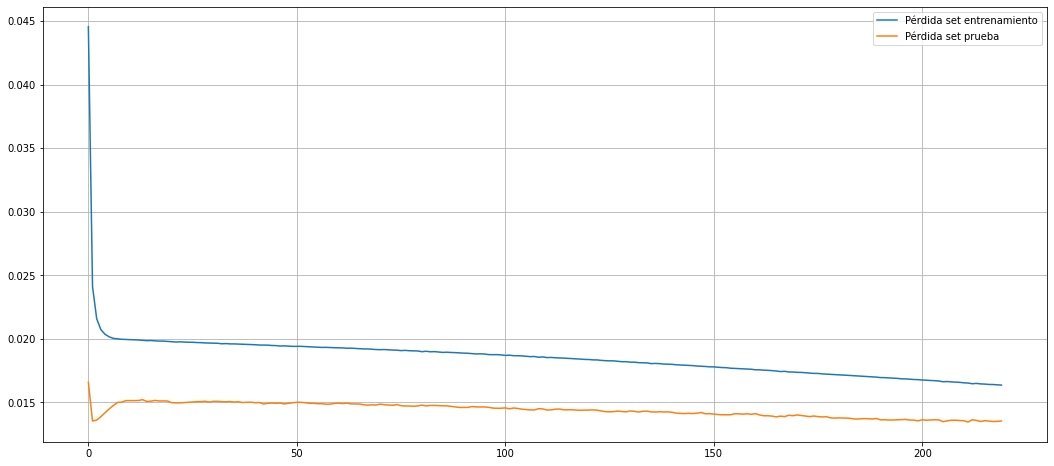

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(historiaAf.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historiaAf.history["val_loss"], label="Pérdida set prueba")
plt.grid()
plt.legend();

In [ ]:
RecAf_Afi = autoencoderAf.predict(DataAf_Var)
RecAf_Neg = autoencoderAf.predict(DataNg_Var)

3/3 [==============================] - 0s 3ms/step


In [ ]:
RecAf_Afi[5] #miro uno de ejemplo

array([0.        , 0.17757145, 0.07246956, 0.        , 0.        ],
      dtype=float32)

In [ ]:
RecAf_Afi.shape, RecAf_Neg.shape

((93, 5), (71, 5))

In [ ]:
dato = 3

In [ ]:
DataAf_Var=DataAf_Var.values
DataNg_Var=DataNg_Var.values

Trato de ver la diferencia de errores entre un grupo y otro

In [ ]:
a = 0
b = 0
i = 1
for i in range(70):
  Dif_normal  = abs(abs(RecAf_Afi[i])-abs(DataAf_Var[i]))
  Dif_anormal = abs(abs(RecAf_Neg[i])-abs(DataNg_Var[i]))
  a = a + Dif_normal
  b = b + Dif_anormal
print(a.sum(),b.sum())

25.830826961279012 47.81074021666946


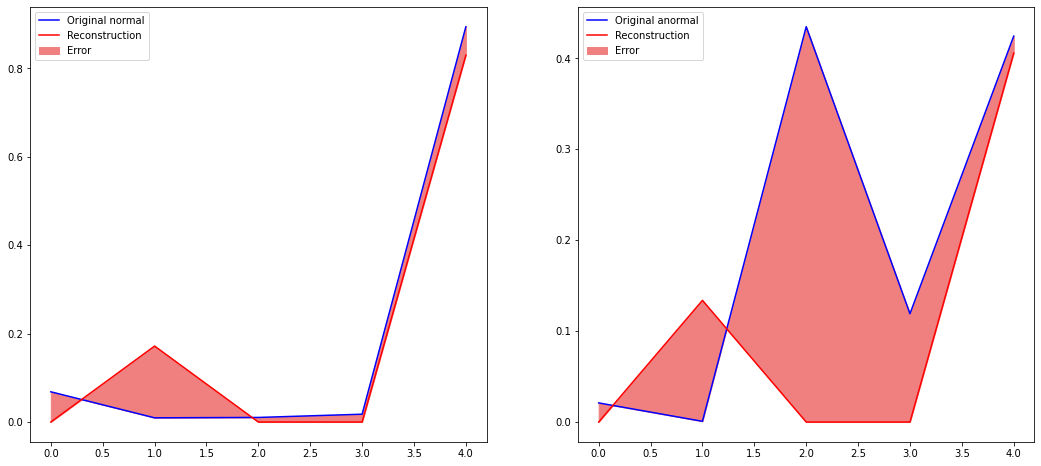

In [ ]:
dato = 50
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)

plt.plot(DataAf_Var[dato],'b')
plt.plot(RecAf_Afi[dato],'r')

plt.fill_between(np.arange(5), RecAf_Afi[dato], DataAf_Var[dato], color='lightcoral')
plt.legend(labels=["Original normal", "Reconstruction", "Error"])

plt.subplot(1,2,2)
plt.plot(DataNg_Var[dato],'b')
plt.plot(RecAf_Neg[dato],'r')

plt.fill_between(np.arange(5), RecAf_Neg[dato], DataNg_Var[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

In [ ]:
import tensorflow as tf

In [ ]:
RecAf_Afi = autoencoderAf.predict(DataAf_Var)
RecAf_Neg = autoencoderAf.predict(DataNg_Var)

3/3 [==============================] - 0s 3ms/step


In [ ]:
#Calculo la perdida (mae) para cada elemento de cada categoria
loss_Af_Af = tf.keras.losses.mae(autoencoderAf.predict(DataAf_Var), DataAf_Var)
loss_Neg_Af = tf.keras.losses.mae(autoencoderAf.predict(DataNg_Var), DataNg_Var)

3/3 [==============================] - 0s 4ms/step


In [ ]:
np.sum(loss_Af_Af)/len(loss_Af_Af)*1000, np.sum(loss_Neg_Af)/len(loss_Neg_Af)*1000

(77.67846012471666, 136.21731622933711)

In [ ]:
loss_Af_Af.shape, loss_Neg_Af.shape

(TensorShape([93]), TensorShape([71]))

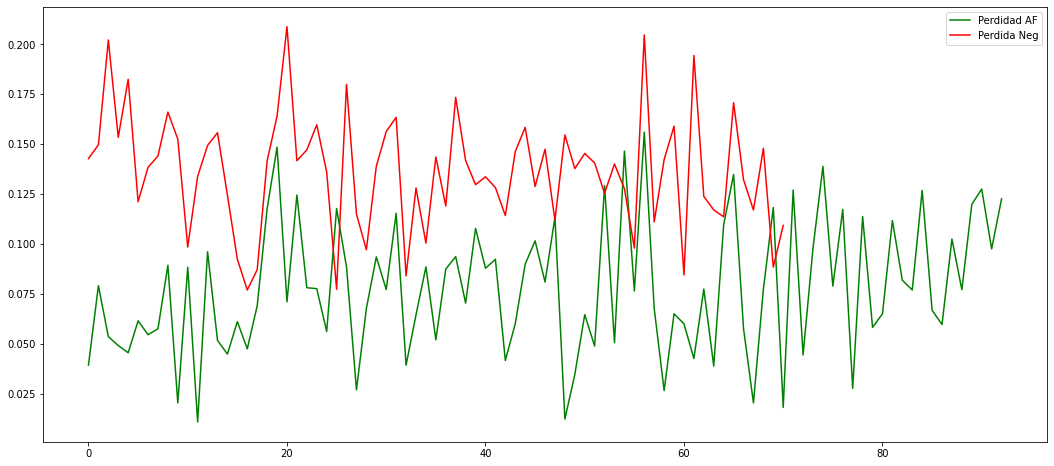

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(loss_Af_Af,'g')
plt.plot(loss_Neg_Af,'r')
plt.legend(labels=["Perdidad AF", "Perdida Neg"]);

In [ ]:
umbral_Af = np.mean(loss_Af_Af)+ np.std(loss_Af_Af)
print("Umbral: ", umbral_Af)

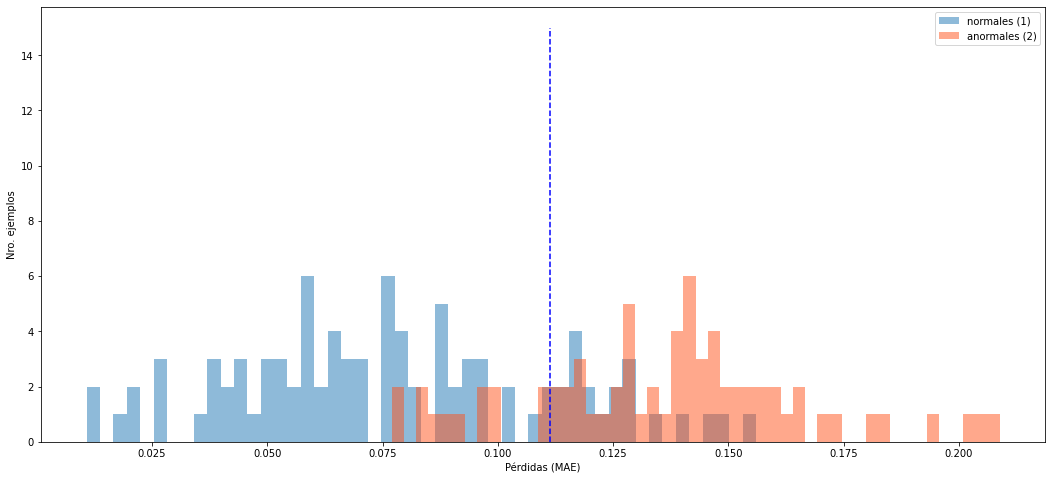

In [ ]:
plt.figure(figsize=(18,8))
plt.hist(loss_Af_Af, bins=50, alpha=0.5, label='normales (1)')
plt.hist(loss_Neg_Af, bins=50, alpha=0.5, color='#ff521b', label='anormales (2)')

plt.xlabel('Pérdidas (MAE)')
plt.ylabel('Nro. ejemplos')
plt.legend(loc='upper right')

plt.vlines(umbral_Af,0,15, linestyles ="dashed", colors ="blue")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dfr_Af = pd.DataFrame(columns=['Umbral_Af', 'Paa1', 'Paa2', 'Esp_Af', 'Pna1', 'Pna2', 'Sen_Af', 'SUM_Af'])

for UR in np.arange(0.01,0.23, 0.01):
  Paa= tf.math.less(loss_Af_Af, UR)
  Paa1 =np.array(Paa).sum()
  Paa2 =np.array(~(Paa)).sum()
  Esp_Af = (Paa1/(Paa1+Paa2)*100)

  Pna= tf.math.less(loss_Neg_Af, UR)
  Pna1 =np.array(Pna).sum()
  Pna2 =np.array(~(Pna)).sum()
  Sen_Af = (Pna2/(Pna1+Pna2)*100)

  dfr_Af=dfr_Af.append({'Umbral_Af':UR, 'Paa1':Paa1, 'Paa2':Paa2, 'Esp_Af':Esp_Af, 'Pna1':Pna1, 'Pna2':Pna2, 'Sen_Af':Sen_Af, 'SUM_Af':Sen_Af+Esp_Af},  ignore_index=True)
  #print("{:.3f}".format(UR), Pa1, Pa2, "{:.2f}".format(Sen), Pn1, Pn2,"{:.2f}".format(Esp), "{:.2f}".format(Sen+Esp))


In [ ]:
dfr_Af.describe().T

,count,mean,std,min,25%,50%,75%,max
Umbral_Af,22.0,0.115000,0.064936,0.01,0.062500,0.115000,0.167500,0.220000
Paa1,22.0,62.590909,34.944390,0.00,33.000000,77.500000,93.000000,93.000000
Paa2,22.0,30.409091,34.944390,0.00,0.000000,15.500000,60.000000,93.000000
Esp_Af,22.0,67.302053,37.574613,0.00,35.483871,83.333333,100.000000,100.000000
Pna1,22.0,28.772727,29.626134,0.00,0.000000,16.000000,62.250000,71.000000
Pna2,22.0,42.227273,29.626134,0.00,8.750000,55.000000,71.000000,71.000000
Sen_Af,22.0,59.475032,41.726949,0.00,12.323944,77.464789,100.000000,100.000000
SUM_Af,22.0,126.777085,23.638806,100.00,105.985915,118.499167,151.851431,161.593215


In [ ]:
dfr_Af

,Umbral_Af,Paa1,Paa2,Esp_Af,Pna1,Pna2,Sen_Af,SUM_Af
0,0.01,0.0,93.0,0.000000,0.0,71.0,100.000000,100.000000
1,0.02,3.0,90.0,3.225806,0.0,71.0,100.000000,103.225806
2,0.03,8.0,85.0,8.602151,0.0,71.0,100.000000,108.602151
3,0.04,12.0,81.0,12.903226,0.0,71.0,100.000000,112.903226
4,0.05,20.0,73.0,21.505376,0.0,71.0,100.000000,121.505376
5,0.06,30.0,63.0,32.258065,0.0,71.0,100.000000,132.258065
6,0.07,42.0,51.0,45.161290,0.0,71.0,100.000000,145.161290
7,0.08,54.0,39.0,58.064516,2.0,69.0,97.183099,155.247615
8,0.09,63.0,30.0,67.741935,6.0,65.0,91.549296,159.291231
9,0.10,69.0,24.0,74.193548,10.0,61.0,85.915493,160.109041


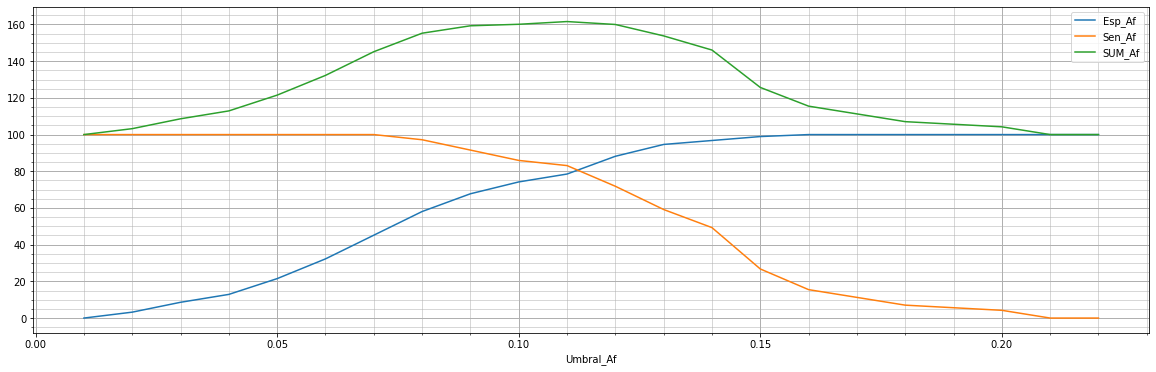

In [ ]:
dfr_Af.plot.line(x='Umbral_Af',y=['Esp_Af', 'Sen_Af','SUM_Af'], figsize=(20,6))#.grid(color='blue',linestyle='dotted')
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.5)
plt.minorticks_on()

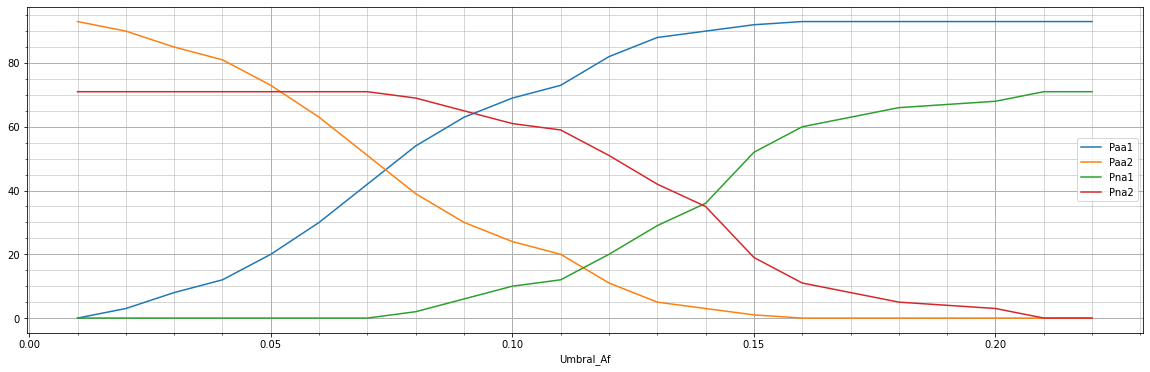

In [ ]:
dfr_Af.plot.line(x='Umbral_Af',y=['Paa1','Paa2', 'Pna1','Pna2'], figsize=(20,6))#.grid(color='blue',linestyle='dotted')
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.5)
plt.minorticks_on()

Es otra prueba!

In [ ]:
#X_pred = autoencoder.predict(X_test)
#ecm = np.mean(np.power(X_test-X_pred,2), axis=1)
#print(X_pred.shape)

In [ ]:
Rec_Var = autoencoderAf.predict(Data_Var)
#X_pred = autoencoder.predict(X_test)
ecm = np.mean(np.power(Data_Var-Rec_Var,2), axis=1)
print(Rec_Var.shape, ecm.shape)

6/6 [==============================] - 0s 2ms/step
(164, 5) (164,)


In [ ]:
Rec_Var

In [ ]:
Data_Var.values

In [ ]:
Rec_Var.shape, ecm.shape

((164, 5), (164,))

In [ ]:
DataAf_Var.shape, DataNg_Var.shape, DataAf_Tg.shape, DataNg_Tg.shape

((93, 5), (71, 5), (93, 1), (71, 1))

In [ ]:
Data.head()

,ETQ,T0,T1,T2,T3,T4
3,1,0.000575,0.168929,0.073724,0.093982,0.662790
4,1,0.088980,0.001149,0.027057,0.088728,0.794086
5,1,0.000957,0.374501,0.001625,0.000749,0.622168
6,1,0.007318,0.277306,0.004724,0.068194,0.642458
7,1,0.013277,0.208851,0.097697,0.044134,0.636041


In [ ]:
Data_Var.shape, Data_Tg.shape

((164, 5), (164, 1))

In [ ]:
DataAf_Tg=DataAf_Tg.values

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

In [ ]:
#loss_Af_Af = tf.keras.losses.mae(autoencoderAf.predict(DataAf_Var), DataAf_Var)
UR = 0.2
Pa= tf.math.less(tf.keras.losses.mae(autoencoderAf.predict(Data_Var), Data_Var), UR)

6/6 [==============================] - 0s 2ms/step


In [ ]:
#PaG= tf.math.less(tf.keras.losses.mae(autoencoderAf.predict(Data_Var), Data_Var), UR)
dfr1 = pd.DataFrame(columns=['URi','TP', 'FP', 'FN', 'TN'])
for URi in np.arange(0.01,0.23, 0.01):
  MC1 =confusion_matrix(np.array(tf.math.less(tf.keras.losses.mae(autoencoderAf.predict(Data_Var), Data_Var), URi)), Data_Tg)
  dfr1=dfr1.append({'URi':URi,'TP':MC1[0][0], 'FP':MC1[0][1], 'FN':MC1[1][0], 'TN':MC1[1][1]},  ignore_index=True)


6/6 [==============================] - 0s 2ms/step


In [ ]:
dfr1

,URi,TP,FP,FN,TN
0,0.01,71.0,93.0,0.0,0.0
1,0.02,71.0,90.0,0.0,3.0
2,0.03,71.0,85.0,0.0,8.0
3,0.04,71.0,81.0,0.0,12.0
4,0.05,71.0,73.0,0.0,20.0
5,0.06,71.0,63.0,0.0,30.0
6,0.07,71.0,51.0,0.0,42.0
7,0.08,69.0,39.0,2.0,54.0
8,0.09,65.0,30.0,6.0,63.0
9,0.10,61.0,24.0,10.0,69.0


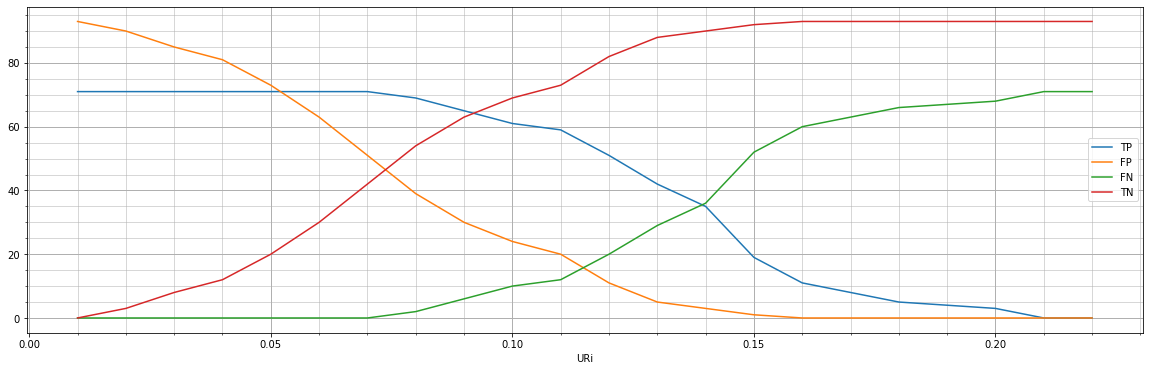

In [ ]:
dfr1.plot.line(x='URi', y=['TP', 'FP', 'FN', 'TN'], figsize=(20,6))#.grid(color='blue',linestyle='dotted')
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.5)
plt.minorticks_on()

In [ ]:
np.array(Pa).sum()

161

In [ ]:
MC =confusion_matrix(np.array(Pa), Data_Tg)
MC

array([[ 3,  0],
       [68, 93]])

In [ ]:
MC.shape

(2, 2)

In [ ]:
MC[0][0]

3

In [ ]:
precision, recall, Umbral = precision_recall_curve(Data_Tg, ecm)

In [ ]:
precision.shape, recall.shape, ecm.shape

((165,), (165,), (164,))

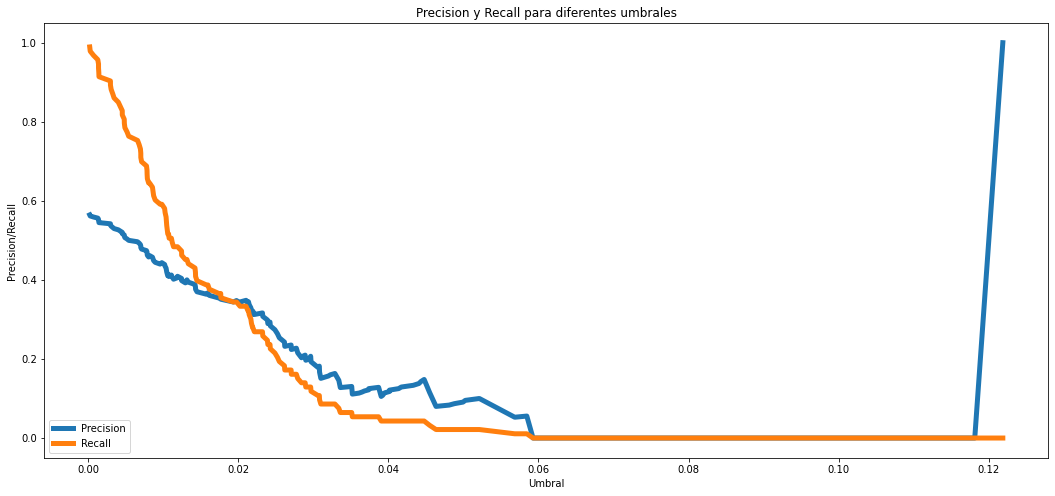

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(Umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(Umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

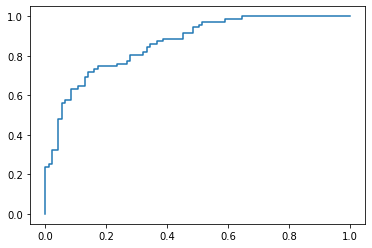

In [ ]:
fpr, tpr, thereshold = roc_curve(Data_Tg, ecm, pos_label=0)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show()

In [ ]:
plot.roc_curve(Data_Tg, ecm)


NameError: ignored

In [ ]:
ecm.shape, len(Rec_Var1), len(Data_Var)

((164,), 164, 164)

In [ ]:

# 5.3. Matriz de confusión
umbral_fijo = 0.005
#Rec_Var1 = autoencoderAf.predict(Data_Var)
Rec_Var1 = [1 if e > umbral_fijo else 0 for e in ecm]

#conf_matrix = confusion_matrix(Data_Var, Rec_Var1)
#print(conf_matrix)

In [ ]:
sum(Rec_Var1), len(Rec_Var1)

(137, 164)

In [ ]:
conf_matrix = confusion_matrix(Data_Var, Rec_Var1)
print(conf_matrix)

ValueError: ignored

Sensitividad y especificidad

- Verdaderos positivos (TP): anormales que han sido correctamente clasificados como anormales
- Falsos negativos (FN): anormales que han sido clasificados erróneamente como normales
- Verdaderos negativos (TN): normales que han sido correctamente clasificados como normales
- Falsos positivos (FP): normales que han sido clasificados erróneamente como anormales

La **sensitividad** mide la proporción de anormales que fueron detectados correctamente como anormales. Una sensitividad del 100% detectará a todos los pacientes enfermos:

$sensitividad = \frac{TP}{TP+FN}$

La **especificidad** mide la proporción de normales que fueron detectados correctamente como normales. Una especificidad del 100% detectará a todos los pacientes sanos:

$especificidad = \frac{TN}{TN+FP}$

Ahora vamos a hacer un encoder para los Negativos y vemos como funciona:

In [ ]:
#Xn_train, Xn_test, yn_train, yn_test = train_test_split(DataNg_Var, DataNg_Tg, test_size=.25, random_state = 0)

In [ ]:
Xn_train.shape, Xn_test.shape, yn_train.shape, yn_test.shape

((53, 5), (18, 5), (53, 1), (18, 1))

In [ ]:
dim_entradaN = Xn_train.shape[1]          # 5
capa_entradaN = Input(shape=(dim_entradaN,))
encoderN = Dense(5, activation='tanh')(capa_entradaN)
encoderN = Dense(4, activation='relu')(encoderN)
encoderN = Dense(3, activation='tanh')(encoderN)

#encoder = Dense(2, activation='relu')(encoder)
#encoder = Dense(2, activation='tanh')(encoder)

encoderN = Dense(3, activation='relu')(encoderN)
decoderN = Dense(4, activation='tanh')(encoderN)
decoderN = Dense(5, activation='relu')(decoderN)
autoencoderNg = Model(inputs=capa_entradaN, outputs=decoderN)
sgd = SGD(learning_rate=0.01)
autoencoderNg.compile(optimizer='sgd', loss='mse')
nits = 150
tam_lote = 1
historiaNg = autoencoderNg.fit(Xn_train, Xn_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(Xn_test, Xn_test), verbose=0)

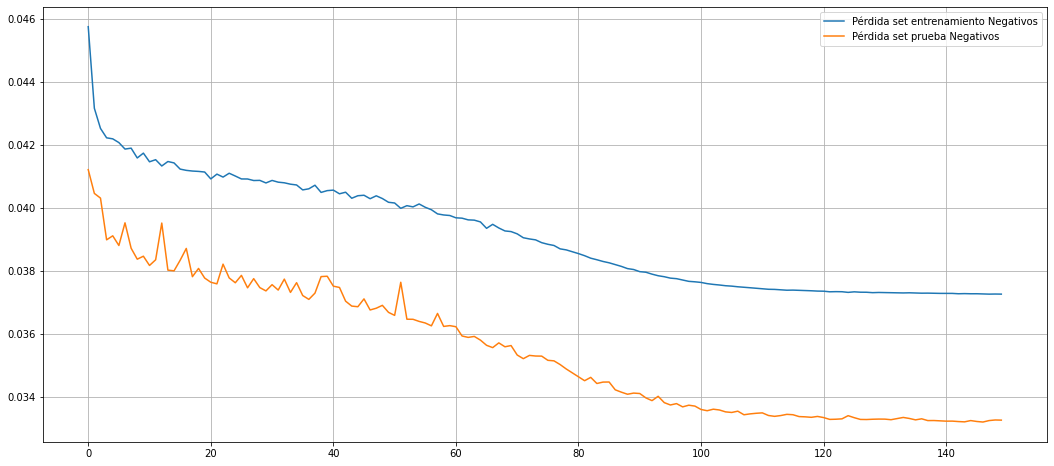

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(historiaNg.history["loss"], label="Pérdida set entrenamiento Negativos")
plt.plot(historiaNg.history["val_loss"], label="Pérdida set prueba Negativos")
plt.grid()
plt.legend()

In [ ]:
RecNg_Afi = autoencoderNg.predict(DataAf_Var)
RecNg_Neg = autoencoderNg.predict(DataNg_Var)

3/3 [==============================] - 0s 3ms/step


In [ ]:
#Calculo la perdida (mae) para cada elemento de cada categoria
loss_Neg_Af = tf.keras.losses.mae(autoencoderNg.predict(DataAf_Var), DataAf_Var)
loss_Neg_Neg = tf.keras.losses.mae(autoencoderNg.predict(DataNg_Var), DataNg_Var)

3/3 [==============================] - 0s 3ms/step


In [ ]:
np.sum(loss_Neg_Neg)/len(loss_Neg_Neg), np.sum(loss_Neg_Af)/len(loss_Neg_Af)

(0.10398815300472507, 0.09767494429934834)

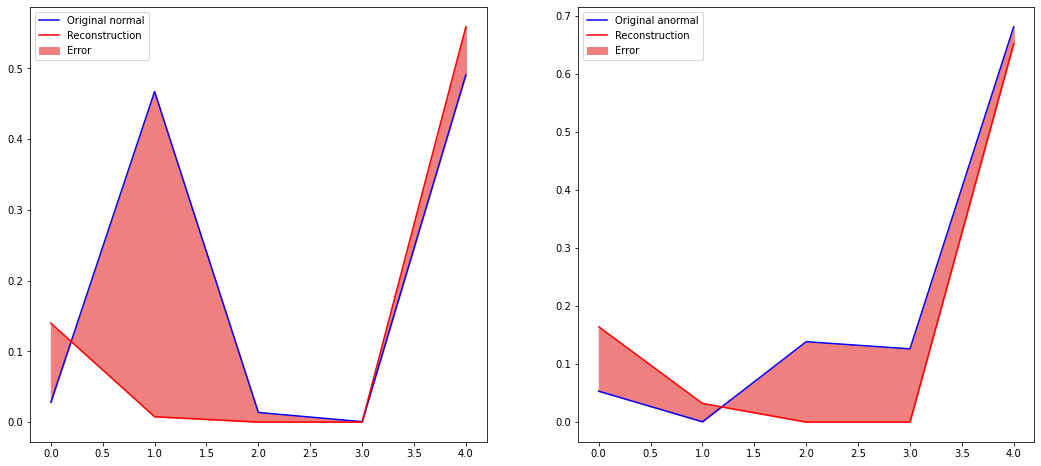

In [ ]:
dato = 10
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)

plt.plot(DataAf_Var[dato],'b')
plt.plot(RecNg_Afi[dato],'r')

plt.fill_between(np.arange(5), RecNg_Afi[dato], DataAf_Var[dato], color='lightcoral')
plt.legend(labels=["Original normal", "Reconstruction", "Error"])

plt.subplot(1,2,2)
plt.plot(DataNg_Var[dato],'b')
plt.plot(RecNg_Neg[dato],'r')

plt.fill_between(np.arange(5), RecNg_Neg[dato], DataNg_Var[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstruction", "Error"])

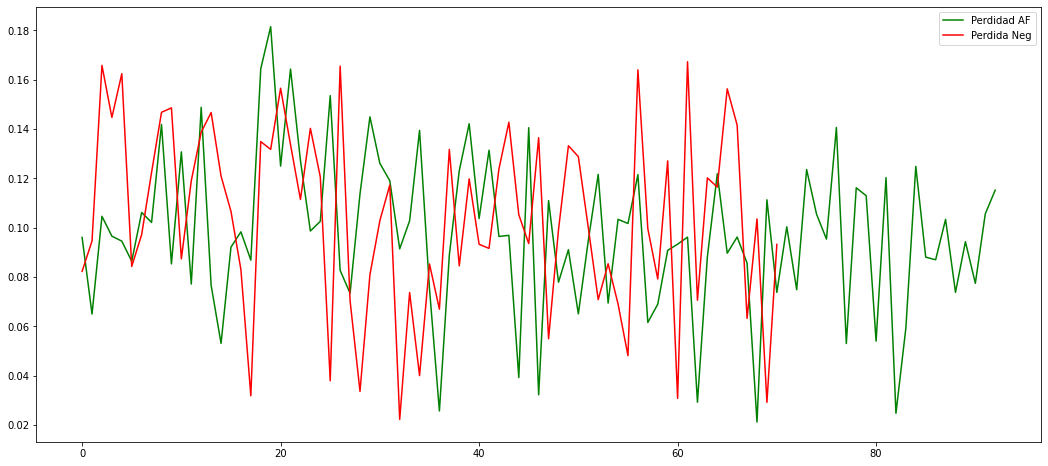

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(loss_Neg_Af,'g')
plt.plot(loss_Neg_Neg,'r')
plt.legend(labels=["Perdidad AF", "Perdida Neg"]);

In [ ]:
umbral_Ng = np.mean(loss_Neg_Neg)+ np.std(loss_Neg_Neg)
print("Umbral: ", umbral_Ng)

Umbral:  0.1416024465838946


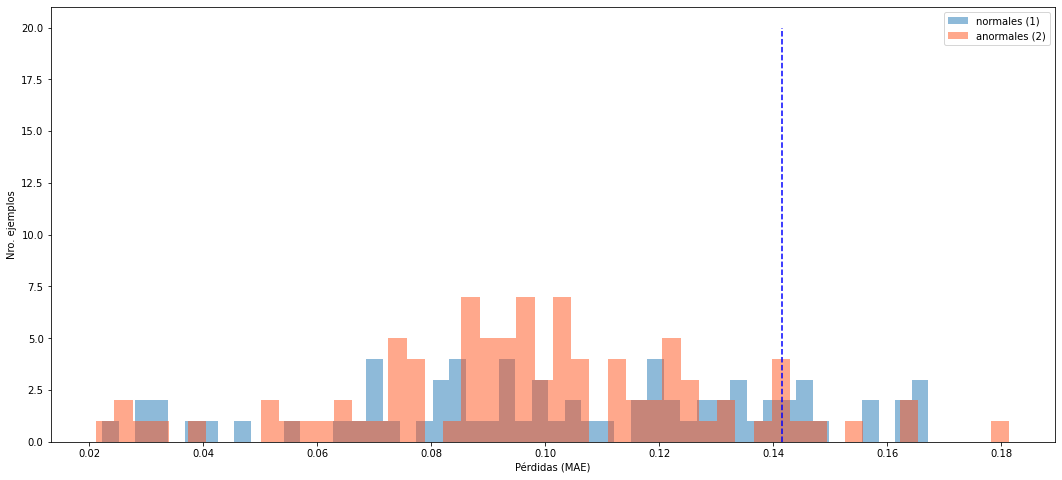

In [ ]:
plt.figure(figsize=(18,8))
plt.hist(loss_Neg_Neg, bins=50, alpha=0.5, label='normales (1)')
plt.hist(loss_Neg_Af, bins=50, alpha=0.5, color='#ff521b', label='anormales (2)')

plt.xlabel('Pérdidas (MAE)')
plt.ylabel('Nro. ejemplos')
plt.legend(loc='upper right')

plt.vlines(umbral_Ng,0,20, linestyles ="dashed", colors ="blue")

In [ ]:
dfr_Ng = pd.DataFrame(columns=['Umbral_Ng', 'Pna1', 'Pna2', 'Esp_Ng', 'Pnn1', 'Pnn2', 'Sen_Ng', 'SUM_Af'])

for UR in np.arange(0.0,0.22, 0.01):
  Pna= tf.math.less(loss_Neg_Af, UR)
  Pna1 =np.array(Pna).sum()
  Pna2 =np.array(~(Pna)).sum()
  Esp_Ng = (Pna1/(Pna1+Pna2)*100)

  Pnn= tf.math.less(loss_Neg_Neg, UR)
  Pnn1 =np.array(Pnn).sum()
  Pnn2 =np.array(~(Pnn)).sum()
  Sen_Ng = (Pnn2/(Pnn1+Pnn2)*100)

  dfr_Ng=dfr_Ng.append({'Umbral_Ng':UR, 'Pna1':Pna1, 'Pna2':Pna2, 'Esp_Ng':Esp_Ng, 'Pnn1':Pnn1, 'Pnn2':Pnn2, 'Sen_Ng':Sen_Ng, 'SUM_NG':Sen_Ng+Esp_Ng},  ignore_index=True)
  #print("{:.3f}".format(UR), Pa1, Pa2, "{:.2f}".format(Sen), Pn1, Pn2,"{:.2f}".format(Esp), "{:.2f}".format(Sen+Esp))
dfr_Ng.head()

,Umbral_Ng,Pna1,Pna2,Esp_Ng,Pnn1,Pnn2,Sen_Ng,SUM_Af,SUM_NG
0,0.00,0.0,93.0,0.000000,0.0,71.0,100.000000,NaN,100.000000
1,0.01,0.0,93.0,0.000000,0.0,71.0,100.000000,NaN,100.000000
2,0.02,0.0,93.0,0.000000,0.0,71.0,100.000000,NaN,100.000000
3,0.03,4.0,89.0,4.301075,2.0,69.0,97.183099,NaN,101.484174
4,0.04,6.0,87.0,6.451613,6.0,65.0,91.549296,NaN,98.000909


In [ ]:
dfr_Ng.describe().T

,count,mean,std,min,25%,50%,75%,max
Umbral_Ng,22.0,0.105000,0.064936,0.000000,0.052500,0.105000,0.157500,0.21000
Pna1,22.0,49.454545,39.032010,0.000000,7.000000,57.000000,89.750000,93.00000
Pna2,22.0,43.545455,39.032010,0.000000,3.250000,36.000000,86.000000,93.00000
Esp_Ng,22.0,53.176931,41.969904,0.000000,7.526882,61.290323,96.505376,100.00000
Pnn1,22.0,35.681818,28.469510,0.000000,8.250000,35.500000,65.500000,71.00000
Pnn2,22.0,35.318182,28.469510,0.000000,5.500000,35.500000,62.750000,71.00000
Sen_Ng,22.0,49.743918,40.097901,0.000000,7.746479,50.000000,88.380282,100.00000
SUM_NG,22.0,102.920849,5.819238,95.184007,99.420718,100.000000,105.122672,115.59897


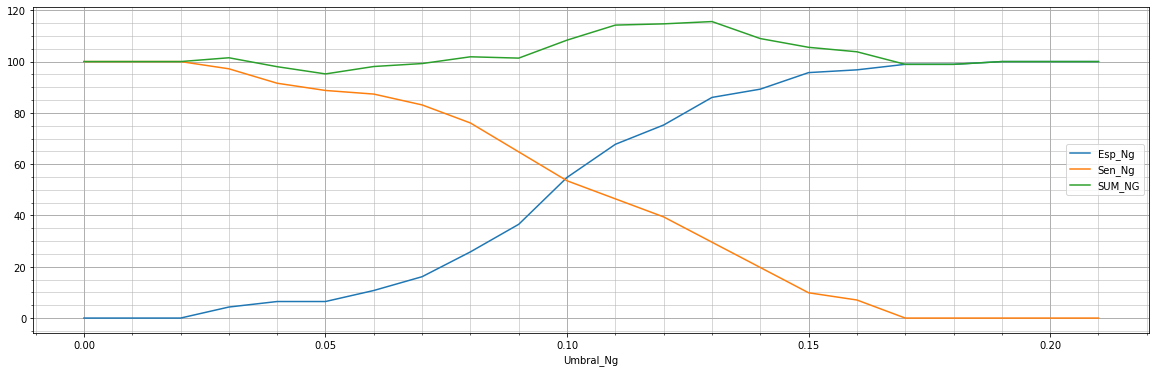

In [ ]:
dfr_Ng.plot.line(x='Umbral_Ng',y=['Esp_Ng','Sen_Ng','SUM_NG'], figsize=(20,6))#.grid(color='blue',linestyle='dotted')
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.5)
plt.minorticks_on()

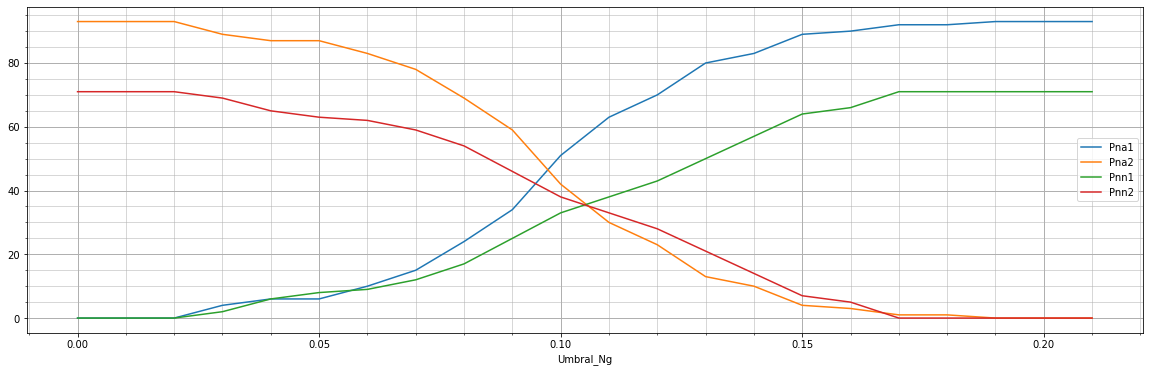

In [ ]:
dfr_Ng.plot.line(x='Umbral_Ng',y=['Pna1','Pna2', 'Pnn1','Pnn2'], figsize=(20,6))#.grid(color='blue',linestyle='dotted')
plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.5)
plt.minorticks_on()

Ahora juntamos los dos encoder para predecir: